In [2]:
import torch
import sys
import os
from pathlib import Path
sys.path.append(os.path.dirname(os.getcwd()))
from src.models.inference import single_piece_predict
from src.models.models import PKSpell
from src.models.process_score import process_score

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using", device)

Using cpu


In [3]:
import pandas as pd 
from sklearn.metrics import accuracy_score
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
plt.style.use(")
import seaborn as sns
from tqdm import tqdm

In [4]:
# !pip install partitura

In [5]:
import partitura

In [6]:
model = torch.load(Path("../models/pkspell.pt"))

## if the load cause problems, loading the state_dict should work
# model = PKSpell()
# model.load_state_dict(torch.load(Path("../models/pkspell_statedict.pt")))

model

PKSpell(
  (rnn): GRU(17, 150, bidirectional=True)
  (rnn2): GRU(300, 12, bidirectional=True)
  (top_layer_pitch): Linear(in_features=300, out_features=36, bias=True)
  (top_layer_ks): Linear(in_features=24, out_features=16, bias=True)
  (loss_pitch): CrossEntropyLoss()
  (loss_ks): CrossEntropyLoss()
)

In [7]:
def abs_path(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            if f.endswith(".xml"):
                yield os.path.abspath(os.path.join(dirpath, f))
            
fnames = [ _ for _ in abs_path("/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/") ]

In [8]:
def spelling(fn):
    
    # PATH = "/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/"
    
    notes = partitura.musicxml_to_notearray(fn, include_pitch_spelling=True)
    
    pcs = [ n[-6] % 12 for n in notes]
    durs = [ n[1] for n in notes]    
    tpcs = [ t[-3] for t in notes ]
    
    partitura_est = [ t[0] for t in partitura.musicanalysis.estimate_spelling(notes) ]
    PKSpell_est, sig_est = single_piece_predict(pcs, durs, model, device)
    
    df = pd.DataFrame(
        { "tpcs" : tpcs,
         "PKSpell_est" : PKSpell_est,
         "partitura_est" : partitura_est
        }
    )
    
    accs = [accuracy_score(df.tpcs, df.PKSpell_est), accuracy_score(df.tpcs, df.partitura_est) ]
    
    return accs
    

In [9]:
len(fnames)

935

In [41]:
N = len(fnames)
pieces = choice(fnames, size=N)

In [42]:
meta = pd.read_csv("data/metadata.csv", sep="\t")
meta.head()

,composer,composer_first,work_group,work catalogue,opus,no,mov,title,composition,publication,...,comment,source,filename,parsed,no_notes,Unnamed: 22,entropy,comp_ID,fifth_width,display_year
0,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,1,NaN,Aime-moi,NaN,1837.0,...,NaN,MS,Un_Morceau_Opus_15_No._1__in_A_Minor_Aime-moi.mxl,1.0,8556.0,NaN,0.549598,1.0,26.0,1837.0
1,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,2,NaN,Le Vent,NaN,1837.0,...,NaN,MS,Un_Morceau_Opus_15_No._2_in_B_Minor_Le_Vent.mxl,1.0,7772.0,NaN,0.234161,1.0,19.0,1837.0
2,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,3,NaN,Morte,NaN,1837.0,...,NaN,MS,Un_Morceau_Opus_15_No._3_in_E_Minor_Morte.mxl,1.0,9685.0,NaN,0.330321,1.0,21.0,1837.0
3,Alkan,Charles Valentin,Scherzi di bravoure,Op.,16,3,NaN,Etude de Bravour,NaN,1837.0,...,NaN,MS,Etude_de_Bravoure_Opus_16_No._3_in_B_Minor.mxl,1.0,8780.0,NaN,0.323257,1.0,18.0,1837.0
4,Alkan,Charles Valentin,Étude de Concert,Op.,17,NaN,NaN,Le Preux,NaN,1844.0,...,NaN,MS,Etude_de_Concert_pour_Piano_Le_Preux_Opus_17.mxl,1.0,11821.0,NaN,0.294673,1.0,22.0,1844.0


In [43]:
%%time
%%capture --no-display
# to disable warnings

both_accs = []
for fn in pieces:
    if fn.split("/")[-1] in meta["filename"].values:
        try:
            date = meta[meta["filename"] == fn.split("/")[-1] ]["display_year"].values.item()
            both_accs.append(spelling(fn) + [date])
        except:
            pass
both_accs = np.array(both_accs)

CPU times: user 14min 2s, sys: 1.78 s, total: 14min 4s
Wall time: 9min 52s


In [46]:
len(both_accs) # how many files are actually parsed

899

In [47]:
df = pd.DataFrame(both_accs, columns=["PKSpell", "ps13", "date"])
df = df.sort_values(by="date").reset_index(drop=True)
df.head()

,PKSpell,ps13,date
0,0.932793,1.0,1361.0
1,0.951739,1.0,1361.0
2,0.952790,1.0,1361.0
3,0.932793,1.0,1361.0
4,0.981707,1.0,1361.0


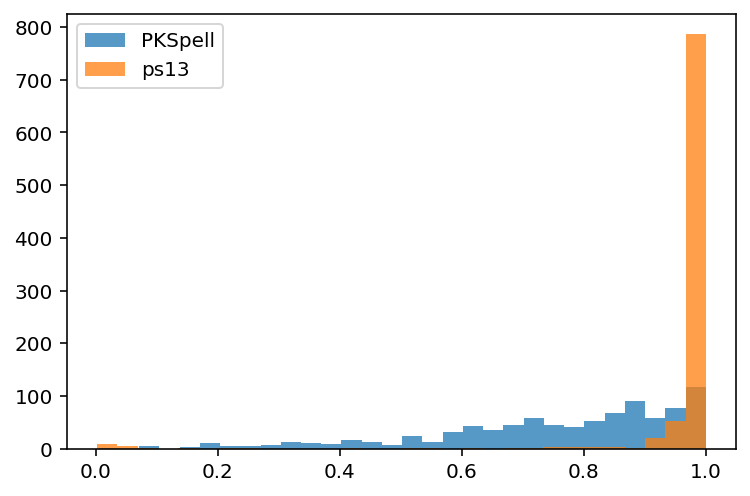

In [48]:
_, ax = plt.subplots()

kws = dict(alpha=.75, bins=30)

ax.hist(df.PKSpell, **kws, label="PKSpell")
ax.hist(df.ps13, **kws, label="ps13")

plt.legend()
plt.show()

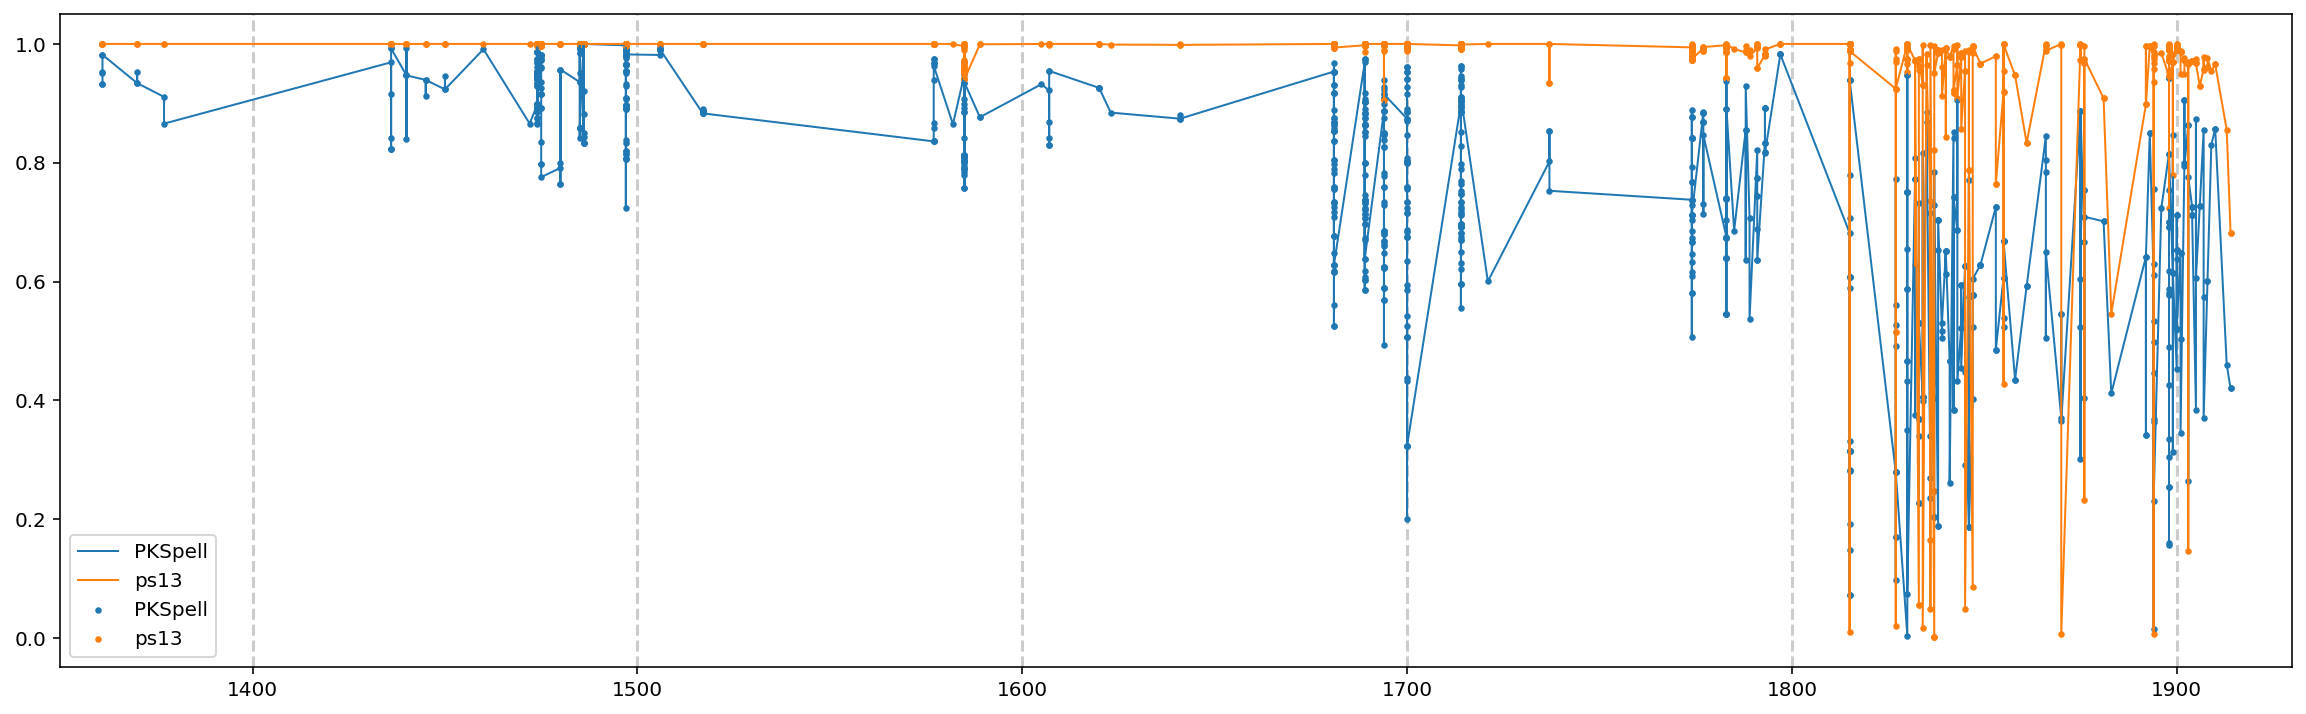

In [124]:
_, ax = plt.subplots(figsize=(20,6))

# lines
ax.plot(df.date, df.PKSpell, label="PKSpell", lw=1)
ax.plot(df.date, df.ps13, label="ps13", lw=1)

# scatter
ax.scatter(df.date, df.PKSpell, label="PKSpell", s=5)
ax.scatter(df.date, df.ps13, label="ps13", s=5)


for c in np.linspace(1400,2000,num=7):
    ax.axvline(c, ls="--", color="grey", zorder=-3, alpha=.4)
    
plt.xlim(1350, 1930)
    
plt.legend()
plt.show()

In [101]:
df.melt(id_vars="date", var_name="algo", value_name="accuracy")

,date,algo,accuracy
0,1361.0,PKSpell,0.932793
1,1361.0,PKSpell,0.951739
2,1361.0,PKSpell,0.952790
3,1361.0,PKSpell,0.932793
4,1361.0,PKSpell,0.981707
...,...,...,...
1793,1910.0,ps13,0.965708
1794,1910.0,ps13,0.965708
1795,1913.0,ps13,0.855385
1796,1914.0,ps13,0.681159


In [43]:
pieces[32]

'/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/Chopin_Frederic/mazurka33-4.xml'

Dvorak Silhouettes (`'/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/Dvorak_Antonin/Dvorak_8_1.0_0.0.xml'`) is a very interesting case. The accuracy is low because of readbility. The piece switches from C# minor to Db major to avoid to many accidentals. This should be fixable by including some notion of tonal distance.

Similarly, Brahms op 118/6 doesn't notate changes of key (comparable to Liszt notating no key signature).

In [12]:
fn = "/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/Machaut_Guillaumede/Cinc-un-treze_Machaut-Guillaume-de_file1.xml"

In [14]:
spelling(fn)

part-group 1 was not ended


[0.910828025477707, 1.0]

In [52]:
# def PKSpelling(piece):
    
#     PATH = "data/DataFrames/"
    
#     piece = pd.read_csv(PATH + piece, index_col=0)
#     piece = piece[ piece["pitch_class"].notnull() & piece["duration"].notnull() ]

#     tpcs = piece["tpc"].str.replace("b", "-").values
#     pcs = piece["pitch_class"].astype(int).values
#     durs = piece["duration"].values
    
#     # predict
#     pcs_pred, durs_pred = single_piece_predict(pcs, durs, model, device)
    
#     # compare
#     df = pd.DataFrame(
#         { "tpc" : tpcs,
#           "pc" : pcs,
#           "estimate" : pcs_pred,
#           "correct" : tpcs == pcs_pred # maybe replace with metric later
#         }
#     )
    
#     # accuracy 
#     acc = accuracy_score(tpcs, pcs_pred)
    
#     return acc

In [10]:
### So Ger6 chords can't occur?

# midi-numbers % 12
p_list = [7,11,2,5]
# any kind of durations, e.g. seconds, milliseconds, quarterLengths, tatums.
d_list = np.ones(len(p_list))

single_piece_predict(p_list, d_list, model, device)

(['G', 'B', 'D', 'F'], [1, 1, 1, 0])

In [11]:
# class Piece(object):
    
#     def __init__(self, fpath):
#         self.fpath = fpath
#         self.data = pd.read_csv("data/DataFrames/" + self.fpath, index_col=0)
#         self.pc_acc = self.spelling_accuracy()
        
#     def spelling_accuracy(self):
#         from src.models.inference import single_piece_predict
#         from sklearn.metrics import accuracy_score
        
#         model = torch.load(Path("../models/pkspell.pt"))
#         device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
#         # predict
#         pitch_data = self.data[self.data["pitch_class"].notnull() & self.data["duration"].notnull()]   
#         self.pcs_pred, self.durs_pred = single_piece_predict(pitch_data.pitch_class, pitch_data.duration, model, device)
        
#         return accuracy_score(pitch_data.tpc, self.pcs_pred)
    

In [12]:
# p = Piece(files[0])
# p.spelling_accur()

In [13]:
files = [ f for f in os.listdir("data/DataFrames") if f.endswith(".csv")]
# files = xmls

frames = [ pd.read_csv("data/DataFrames/" + f, index_col=0) for f in files ]

In [15]:
meta = pd.read_csv("data/metadata.csv", sep="\t")
# dates = [ meta[ meta["filename"] == f[:-4] ]["display_year"].values for f in files ]

In [16]:
dates = []
fnames = []

for fr, fi in zip(frames, files):
    date = meta[meta.filename == fi[:-4]]["display_year"].values
    try:
        dates.append(date[0])
        fnames.append(fi)
    except:
        pass

In [17]:
# files = [ f "data/DataFrames/" + for f in os.listdir("data/DataFrames") if f.endswith(".csv")]
N = len(fnames)
pieces = choice(fnames, size=N)

accs = [ PKSpelling(piece) for piece in tqdm(pieces) ]

100%|██████████| 2003/2003 [03:59<00:00,  8.37it/s]


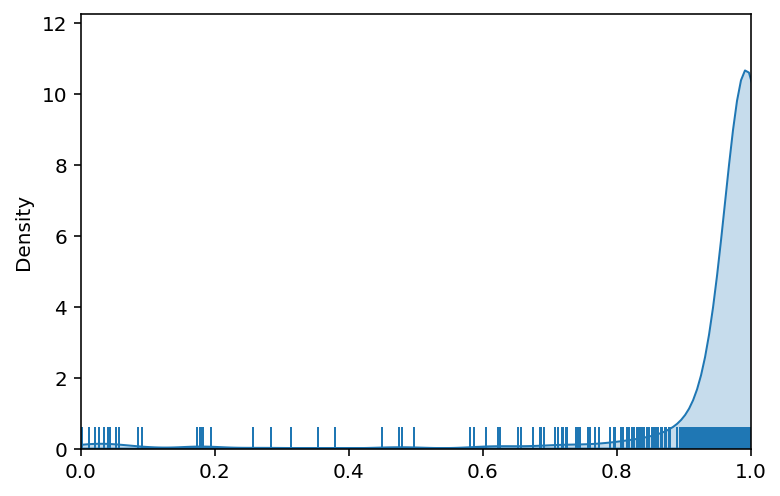

In [18]:
_, ax = plt.subplots()
sns.kdeplot(accs, fill=True, ax=ax)
sns.rugplot(accs, ax=ax, height=.05)

plt.xlim(0,1)
plt.show()

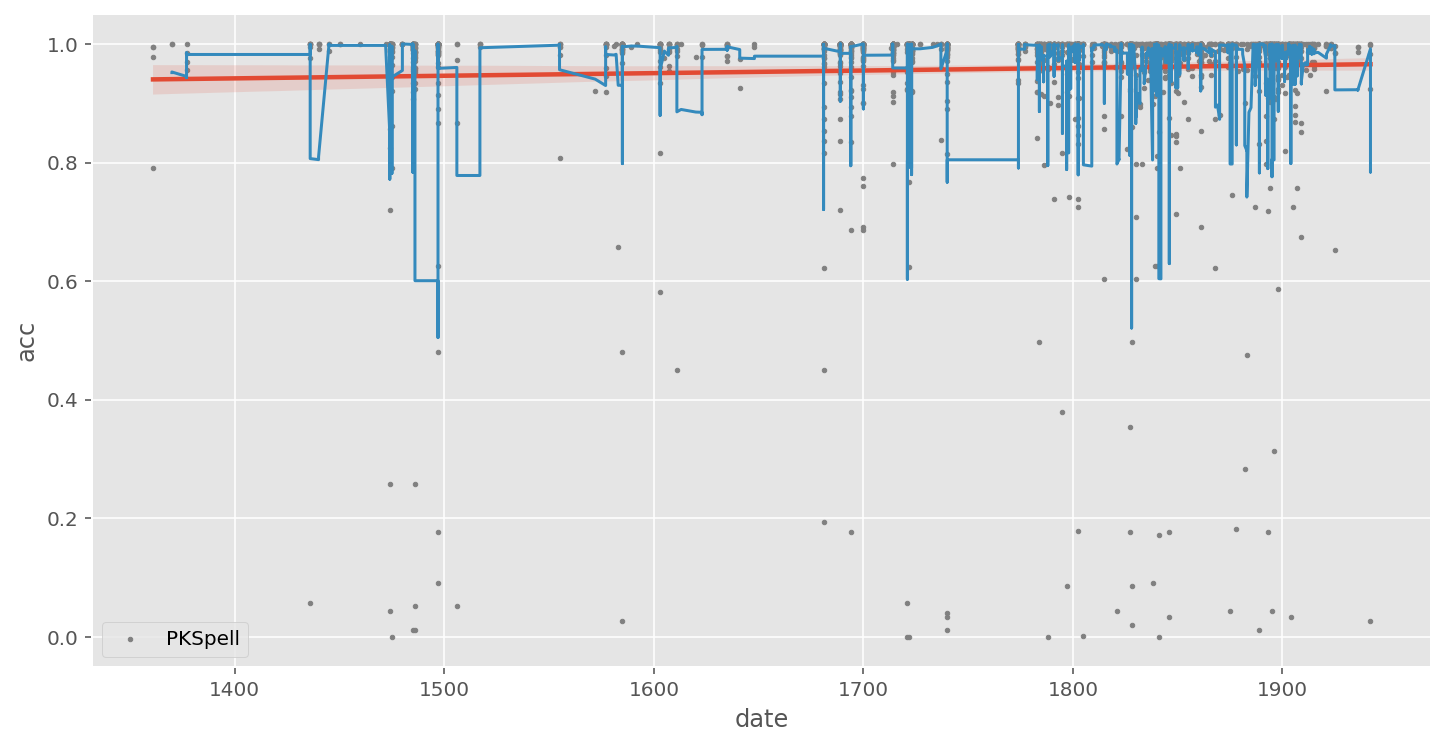

In [27]:
df = pd.DataFrame(
    {
        "date" : dates,
        "acc" : accs
    }
)

df = df.sort_values(by="date").reset_index(drop=True)

# filter "too easy" pieces
# df = df[df.acc < .99]

df["rolling_mean"] = df["acc"].rolling(window=5).mean()

plt.style.use("ggplot")

_, ax = plt.subplots(figsize=(12,6))

x = df.date
y = df.acc

ax.scatter(
    x,
    y,
    s = 5,
    c="gray",
    label = "PKSpell"
)

sns.regplot(
    x=x,
    y=y,
    scatter=False,
    order=1,
    ax=ax)

ax.plot(df.date, df.rolling_mean)

plt.legend()
plt.show()

In [131]:
# for i, d in enumerate(dates):
#     print(i, d)

In [132]:
dates = [ d.values[0] for d in dates ]
dates[:3]

[]

In [133]:
for d in dates:
    try:
        i = d.item()
    except:
        print(d)

In [95]:
len(dates)

1